In [133]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from scipy.stats import norm
from scipy.stats import pearsonr
from datetime import datetime, timedelta
from tqdm import tqdm
from time import time

# TASK 1

In [134]:
def cont_comp_returns(sol):
    return np.diff(sol) / sol[:-1]

def year_return(stocks, weights, periods):
    return (1+np.sum((stocks.mean() * weights)))**periods - 1

def year_std(stocks, weights, periods):
    return np.sqrt(np.dot(weights.T, np.dot(stocks.cov() , weights))) * np.sqrt(periods)

In [3]:
yahoo_financials1 = YahooFinancials('AAPL')
data1 = yahoo_financials1.get_historical_price_data(start_date='2010-01-01',
                                                    end_date='2021-12-31',
                                                    time_interval='weekly')
comp_df = pd.DataFrame(data1['AAPL']['prices'])
aapl = cont_comp_returns(comp_df['close']).dropna()

yahoo_financials2 = YahooFinancials('PG')
data2 = yahoo_financials2.get_historical_price_data(start_date='2010-01-01',
                                                    end_date='2021-12-31',
                                                    time_interval='weekly')
comp_df = pd.DataFrame(data2['PG']['prices'])
pg = cont_comp_returns(comp_df['close']).dropna()

yahoo_financials2 = YahooFinancials('TSLA')
data2 = yahoo_financials2.get_historical_price_data(start_date='2010-01-01',
                                                    end_date='2021-12-31',
                                                    time_interval='weekly')
comp_df = pd.DataFrame(data2['TSLA']['prices'])
tsla = cont_comp_returns(comp_df['close']).dropna()

yahoo_financials2 = YahooFinancials('VGT')
data2 = yahoo_financials2.get_historical_price_data(start_date='2010-01-01',
                                                    end_date='2021-12-31',
                                                    time_interval='weekly')
comp_df = pd.DataFrame(data2['VGT']['prices'])
vgt = cont_comp_returns(comp_df['close']).dropna()

yahoo_financials2 = YahooFinancials('BNDX')
data2 = yahoo_financials2.get_historical_price_data(start_date='2010-01-01',
                                                    end_date='2021-12-31',
                                                    time_interval='weekly')
comp_df = pd.DataFrame(data2['BNDX']['prices'])
bndx = cont_comp_returns(comp_df['close']).dropna()

yahoo_financials2 = YahooFinancials('AMZN')
data2 = yahoo_financials2.get_historical_price_data(start_date='2010-01-01',
                                                    end_date='2021-12-31',
                                                    time_interval='weekly')
comp_df = pd.DataFrame(data2['AMZN']['prices'])
amzn = cont_comp_returns(comp_df['close']).dropna()

Сгенерируем различные варинты портфелей на которых проверим равенства

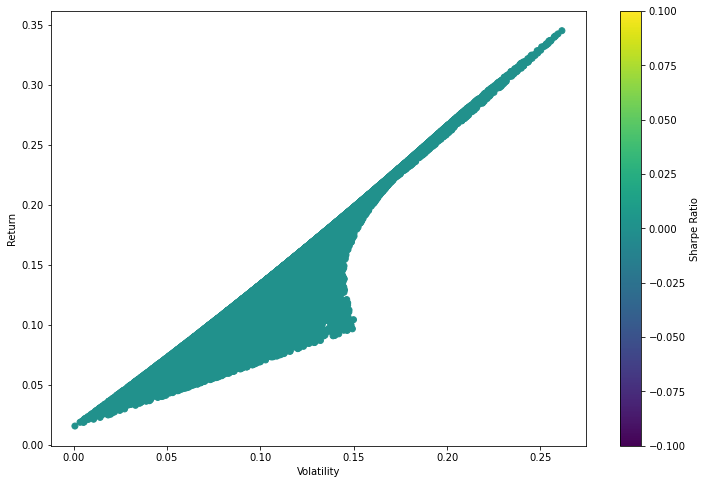

AAPL_ret    0.005454
PG_ret      0.001524
dtype: float64 [0.00599217 0.00164308]
AAPL_ret   -0.000538
PG_ret     -0.000119
dtype: float64 res


In [136]:
#d
rs_rate = 0.015
stocks = pd.DataFrame()
stocks['AAPL_ret'] =  aapl
stocks['PG_ret'] = pg
stocks['Risk_free'] = np.ones(stocks.shape[0]) * np.power(1+ rs_rate, 1/52) - 1



np.random.seed(42)
num_ports = 28000
risk_aversion = 20
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
std_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)


for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(3))
    weights = weights/np.sum(weights)


    # Save weights
    all_weights[x,:] = weights

    # Expected return
    ret_arr[x] = (1+np.sum((stocks.mean() * weights)))**52 - 1

    # Expected volatility
    std_arr[x] = np.sqrt(np.dot(weights.T, np.dot(stocks.cov() , weights))) * np.sqrt(52)

U = (ret_arr - (risk_aversion/2) * np.square(std_arr))

opt_solution, opt_solution_idx = np.max(U), np.argmax(U)
opt_weights = all_weights[opt_solution_idx]
opt_returns = (stocks * opt_weights).sum(axis = 1)
stocks['Optimal'] = opt_returns



plt.figure(figsize=(12,8))
plt.scatter(std_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
#plt.scatter(min_std, min_std_ret,c='red', s=50) # red dot
plt.show()



left_part = stocks[['AAPL_ret', 'PG_ret']].mean() - stocks['Risk_free'].mean()
#print(left_part)
right_part = (risk_aversion * np.cov(stocks.T)[[0,1],-1])
#print(right_part)
res = left_part - right_part
print(left_part, right_part)
print(res, 'res')

(a) Чтобы доказать следующие соотношения сгенерируем портфель, посчитаем левые и правые части.

In [137]:
#b
examples = 10

diff = []
portfolios_idx = np.flip(np.argsort(U))[:examples]
chosen_weights = all_weights[portfolios_idx]
for weights in chosen_weights:
    Rf = stocks['Risk_free'].mean()
    Rp = np.expand_dims((stocks[['AAPL_ret', 'PG_ret', 'Risk_free']] * weights).sum(axis = 1).to_numpy(), axis =1)
    Rp_mean = Rp.mean()
    Rp_var = Rp.var(ddof=0)

    Ri_returns = stocks[['AAPL_ret', 'PG_ret']].to_numpy()
    Ri_mean = Ri_returns.mean()

    left_part = Ri_mean - Rf

    cov_inp = np.hstack((Ri_returns, Rp))

    cov = np.cov(np.hstack((Ri_returns, Rp )).T)[:-1, -1]

    beta = cov/Rp_var
    right_part = beta * (Rp_mean - Rf)
    diff_value = left_part - right_part
    diff.append(diff_value)

diff

[array([-0.00198438,  0.00198822]),
 array([-0.0019757 ,  0.00196683]),
 array([-0.0019675 ,  0.00194801]),
 array([-0.00199533,  0.00201786]),
 array([-0.00198912,  0.00200063]),
 array([-0.00197878,  0.00197424]),
 array([-0.00196868,  0.00195065]),
 array([-0.00194165,  0.00189526]),
 array([-0.00197486,  0.00196486]),
 array([-0.00193831,  0.00188903])]

In [139]:
# c
from sklearn.linear_model import LinearRegression


def Linreg_company(ticker, num_samples, stocks, U):
    Ri = stocks[ticker].to_numpy()
    Rf = stocks['Risk_free'][0]
    portfolios_idx = np.flip(np.argsort(U))[:num_samples]
    chosen_weights = all_weights[portfolios_idx]

    beta1_lr_arr = []
    beta1_analytic_arr = []
    beta0_lr_arr = []
    error_mean_arr = []
    error_cov_arr = []

    for weights in chosen_weights:
        Rp = np.expand_dims((stocks[['AAPL_ret', 'PG_ret', 'Risk_free']] * weights).sum(axis = 1).to_numpy(), axis =1)
        #Rp_mean = Rp.mean()
        #Rp_var = Rp.var()

        #Calculate regression coeffs
        reg_apl = LinearRegression().fit((Rp - Rf), Ri)
        beta1_lr = reg_apl.coef_[0]
        beta0_lr = reg_apl.intercept_
        beta0_lr_arr.append(beta0_lr)
        beta1_lr_arr.append(beta1_lr)

        #Calculate error and beta1

        Ri_pred = beta0_lr + beta1_lr * (Rp - Rf)
        error = (Rp - Ri_pred).squeeze()
        error_mean = np.mean(error)
        error_cov = np.cov(Rp.squeeze(), error)[0][1]
        error_mean_arr.append(error_mean)
        error_cov_arr.append(error_cov)

        beta1_anal = np.cov(Ri, Rp.squeeze())[0][1] / (Rp.squeeze() - Rf).var()
        beta1_analytic_arr.append(beta1_anal)

    beta0_diff = np.mean(beta0_lr_arr) - Rf
    beta1_diff = np.mean(beta1_lr_arr) - np.mean(beta1_analytic_arr)
    error_mean_fin = np.mean(error_mean_arr)
    error_cov_fin = np.mean(error_cov_arr)


    return beta0_diff, beta1_diff, error_mean_fin, error_cov_fin


a,b,c,d = Linreg_company('AAPL_ret', 10, stocks, U)
print(a,b,c,d)


2.556706864840282e-06 -0.006834873288692478 -0.004175179402238648 -0.00022654854518523623


In [140]:
#d
num_samples = 10
portfolios_idx = np.flip(np.argsort(U))[:num_samples]
chosen_weights = all_weights[portfolios_idx]

Rf = stocks['Risk_free'][0]
SR = []
for weights in chosen_weights:
    Rp = (stocks[['AAPL_ret', 'PG_ret', 'Risk_free']] * weights).sum(axis = 1).to_numpy()
    Rp_mean = Rp.mean()
    Rp_std = Rp.std()
    sr = (Rp_mean - Rf)/ Rp_std
    SR.append(sr)

print(np.mean(SR), np.std(SR))

0.15359489767467363 1.849261960314837e-05


Так как разность левой и правой части получилось очень маленькой, то тождество доказано.

# TASK 2

In [151]:
tickers = ['AXP', 'BA', 'CAT', 'CVX', 'DIS', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO',
           'MCD', 'MMM', 'MRK', 'PFE', 'PG', 'TRV', 'RTX', 'WBA', 'WMT', 'XOM']
rs_rate = 0.015
df = pd.DataFrame()

for ticker in tickers:
    yahoo_financials = YahooFinancials(ticker)
    yahoo_data = yahoo_financials.get_historical_price_data(start_date='1978-01-01',
                                                            end_date='2021-12-31',
                                                            time_interval='monthly')
    temp_df = pd.DataFrame(yahoo_data[ticker]['prices'])

    df[ticker] = cont_comp_returns(temp_df['close'])
df['Risk_free'] = np.ones(df.shape[0]) * np.power(1 + rs_rate/12, 1/12) - 1
df.to_csv('tickers_close_prices.csv')
df

,AXP,BA,CAT,CVX,DIS,IBM,INTC,JNJ,JPM,KO,...,MMM,MRK,PFE,PG,TRV,RTX,WBA,WMT,XOM,Risk_free
0,-0.002915,0.050100,-0.014981,0.010949,0.047059,-0.053672,-0.089431,0.009616,0.050000,0.058334,...,-0.028148,0.040365,0.018987,0.011111,0.068396,-0.023323,0.078680,0.000000,-0.010417,0.000104
1,-0.032164,-0.045802,-0.030418,0.007220,0.011237,-0.062687,-0.008928,0.066666,-0.047619,0.102362,...,0.003049,0.050063,0.065217,-0.024176,0.086093,-0.023881,0.021177,-0.019231,0.057895,0.000104
2,0.042296,-0.034000,-0.007843,0.064516,-0.026985,0.129512,-0.009008,0.044643,0.010000,-0.021429,...,-0.063830,-0.029798,0.037901,-0.060811,0.079268,-0.067278,-0.078341,0.050421,0.024876,0.000104
3,0.066667,0.101449,0.094862,-0.037037,0.135400,-0.029135,-0.040910,0.071225,0.092409,-0.009124,...,-0.025974,0.060197,0.123596,0.033573,0.047081,0.147541,0.150000,0.117333,0.048544,0.000104
4,0.032609,0.009398,-0.043321,0.045455,0.079023,-0.003872,-0.014217,-0.013298,-0.003021,0.022099,...,0.040000,0.044032,-0.010000,0.041763,0.043165,-0.051429,-0.039130,0.042959,-0.002315,0.000104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,-0.026799,-0.030819,0.019927,-0.049504,0.029997,0.003287,0.006329,0.005401,0.053828,-0.012625,...,-0.016166,-0.007545,0.076150,0.001125,0.072455,-0.025187,0.076352,0.038934,-0.052979,0.000104
439,0.009460,0.002005,-0.089629,0.048362,-0.066906,-0.012844,-0.014428,-0.067175,0.023382,-0.068194,...,-0.099209,-0.015467,-0.066421,-0.018189,-0.048212,0.014158,-0.072906,-0.058879,0.078870,0.000104
440,0.037307,-0.058698,0.062718,0.128536,-0.000591,-0.133962,-0.080330,0.008545,0.037876,0.074328,...,0.018584,0.172281,0.016973,0.022818,0.058351,0.033737,-0.000638,0.072033,0.096056,0.000104
441,-0.123605,-0.044341,-0.052252,-0.014150,-0.142959,-0.013564,0.004082,-0.042670,-0.065101,-0.069541,...,-0.048355,-0.149233,0.228395,0.011120,-0.086586,-0.089354,-0.047214,-0.058827,-0.071816,0.000104


In [155]:
df = pd.read_csv('tickers_close_prices.csv')
df = df.drop(columns = ['Unnamed: 0'])

In [156]:
df

,AXP,BA,CAT,CVX,DIS,IBM,INTC,JNJ,JPM,KO,...,MMM,MRK,PFE,PG,TRV,RTX,WBA,WMT,XOM,Risk_free
0,-0.002915,0.050100,-0.014981,0.010949,0.047059,-0.053672,-0.089431,0.009616,0.050000,0.058334,...,-0.028148,0.040365,0.018987,0.011111,0.068396,-0.023323,0.078680,0.000000,-0.010417,0.000104
1,-0.032164,-0.045802,-0.030418,0.007220,0.011237,-0.062687,-0.008928,0.066666,-0.047619,0.102362,...,0.003049,0.050063,0.065217,-0.024176,0.086093,-0.023881,0.021177,-0.019231,0.057895,0.000104
2,0.042296,-0.034000,-0.007843,0.064516,-0.026985,0.129512,-0.009008,0.044643,0.010000,-0.021429,...,-0.063830,-0.029798,0.037901,-0.060811,0.079268,-0.067278,-0.078341,0.050421,0.024876,0.000104
3,0.066667,0.101449,0.094862,-0.037037,0.135400,-0.029135,-0.040910,0.071225,0.092409,-0.009124,...,-0.025974,0.060197,0.123596,0.033573,0.047081,0.147541,0.150000,0.117333,0.048544,0.000104
4,0.032609,0.009398,-0.043321,0.045455,0.079023,-0.003872,-0.014217,-0.013298,-0.003021,0.022099,...,0.040000,0.044032,-0.010000,0.041763,0.043165,-0.051429,-0.039130,0.042959,-0.002315,0.000104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,-0.026799,-0.030819,0.019927,-0.049504,0.029997,0.003287,0.006329,0.005401,0.053828,-0.012625,...,-0.016166,-0.007545,0.076150,0.001125,0.072455,-0.025187,0.076352,0.038934,-0.052979,0.000104
439,0.009460,0.002005,-0.089629,0.048362,-0.066906,-0.012844,-0.014428,-0.067175,0.023382,-0.068194,...,-0.099209,-0.015467,-0.066421,-0.018189,-0.048212,0.014158,-0.072906,-0.058879,0.078870,0.000104
440,0.037307,-0.058698,0.062718,0.128536,-0.000591,-0.133962,-0.080330,0.008545,0.037876,0.074328,...,0.018584,0.172281,0.016973,0.022818,0.058351,0.033737,-0.000638,0.072033,0.096056,0.000104
441,-0.123605,-0.044341,-0.052252,-0.014150,-0.142959,-0.013564,0.004082,-0.042670,-0.065101,-0.069541,...,-0.048355,-0.149233,0.228395,0.011120,-0.086586,-0.089354,-0.047214,-0.058827,-0.071816,0.000104


In [157]:
def calc_weights(window, strategy, rf=0.015, ra=7, RF = True,num_assets=20):
    if strategy == 'TAN':
        return TAN(window, rf, ra , RF)
    elif strategy == 'GMV':
        return GMV(window, rf, 20, RF)
    elif strategy == 'RP':
        return RP(window, RF)
    elif strategy == 'EW':
        return EW(num_assets, RF)


def run_strategy(strategy, stocks, rf = 0.015, ra = 10, RF = True):
    start  = 12 * 10
    end = len(stocks)
    profits = []
    final_profit = 1
    for t in tqdm(np.arange(start, end , 1)):

        stat_window = stocks.iloc[t - start : t, :]
        #print(stat_window)
        weights = calc_weights(stat_window, strategy, rf, ra, 21)
        #print( stat_window.shape)
        #print(weights.sum())
        #print(weights)
        #print(weights.shape, stocks.iloc[t,:] )
        month_return = (stocks.iloc[t,:] * weights).sum()
        final_profit = final_profit * (1 + month_return)
        profits.append(month_return)
        #print(t)
    return profits, final_profit



def TAN(window, rf, ra, RF = True):


    if (RF):
        #print(RF)
        mu = window.iloc[:,:20].mean()
        cov1 = np.cov(window.iloc[:,:20].T)
        #print(cov1.shape)
        R0 = np.ones(20) * rf
        #print(np.linalg.inv(cov1).shape)
        wtan = np.linalg.inv(cov1) @ (mu - R0)
        wtan = np.where(wtan > 0, wtan, 0)
        C = wtan.sum()
        wtan  = wtan/C
        wa = (C/ra) * wtan
        w0 = 1 - C/ra
        wa = np.append(wa, w0)
        wa =  np.where(wa > 0, wa, 0)
        wa = wa/wa.sum()
        return wa
    else:
        mu = window.iloc[:,:20].mean()
        cov1 = np.cov(window.iloc[:,:20].T)
        #print(cov1.shape)
        R0 = np.ones(20) * rf
        #print(np.linalg.inv(cov1).shape)
        wtan = np.linalg.inv(cov1) @ (mu - R0)
        wtan = np.where(wtan > 0, wtan, 0)
        C = wtan.sum()
        wtan  = wtan/C
        return wtan


def EW(num_assets, RF = True):
    if (RF):
        return 1/(num_assets+1) * np.ones(num_assets+1)
    else:
        return 1/num_assets * np.ones(num_assets)

def GMV(window, rf, num_assets, RF = True):

    if (RF):
        num_assets += 1
    np.random.seed(42)
    num_ports = 1000
    all_weights = np.zeros((num_ports, num_assets))
    ret_arr = np.zeros(num_ports)
    std_arr = np.zeros(num_ports)

    for x in range(num_ports):
    # Weights

        weights = np.array(np.random.random(num_assets))
        weights = weights/np.sum(weights)
     # Save weights
        all_weights[x,:] = weights
    # Expected return
        ret_arr[x] = (window.mean() * weights).sum()
    # Expected volatility
        std_arr[x] = np.sqrt(np.dot(weights.T, np.dot(window.cov() , weights)))

    gmv_weights_idx = std_arr.argmin()
    gmv_weights = all_weights[gmv_weights_idx]

    return gmv_weights

def RP(window, RF):
    if (RF):
        std_arr = window.iloc[:,:20].std()
        weights = (np.ones(20)/ std_arr)
        weights = weights/ weights.sum()
        weights = np.append(weights, 0)
    else:
        std_arr = window.iloc[:,:20].std()
        weights = (np.ones(20)/ std_arr)
        weights = weights/ weights.sum()

    return weights


In [145]:
def annulize_mean(returns):
    mean_return = np.mean(returns)
    mean_annulized = (1 + mean_return)**12 - 1
    return mean_annulized

def annulize_std(returns):
    mean_std = np.std(returns) * math.sqrt(12)
    return mean_std

Rf = np.power(1 + rs_rate/12, 1/12) - 1

In [158]:
profits1, final_profit1  = run_strategy('TAN', df, 0.015, 5, True)

print(final_profit1)


mean1 = annulize_mean(profits1)
std1 = annulize_std(profits1)
SR1 = (mean1 - Rf)/std1
print(mean1, std1, SR1)

100%|██████████| 323/323 [00:00<00:00, 1144.72it/s]

11.226768458490124
0.11084402452057462 0.17482145745888242 0.633445797185145


In [159]:
profits2, final_profit2  = run_strategy('GMV', df, 0.015, 5)
print(final_profit2)

mean2 = annulize_mean(profits2)
std2 = annulize_std(profits2)
SR2 = (mean2 - Rf)/std2
print(mean2, std2, SR)

100%|██████████| 323/323 [01:57<00:00,  2.74it/s]

10.741296450525345
0.09931120950913774 0.11385645959001595 [0.15360366435973252, 0.1536094583879298, 0.15360756070518444, 0.15358198549221683, 0.15359649258060215, 0.15360839850156868, 0.15360822799691054, 0.1535660776114922, 0.1536095692725653, 0.15355754183853368]


In [160]:
profits3, final_profit3  = run_strategy('RP', df, 0.015, 5)
print(final_profit3)

mean3 = annulize_mean(profits3)
std3 = annulize_std(profits3)
SR3 = (mean3 - Rf)/std3
print(mean3, std3)

100%|██████████| 323/323 [00:00<00:00, 1718.48it/s]

14.433390544501838
0.11416413708870898 0.1334988204016406


In [161]:
profits4, final_profit4  = run_strategy('EW', df, 0.015, 5)
print(final_profit4)

mean4 = annulize_mean(profits4)
std4 = annulize_std(profits4)
SR4 = (mean4 - Rf)/std4
print(mean4, std4)

100%|██████████| 323/323 [00:00<00:00, 4654.86it/s]

14.254218895571567
0.11347569618262288 0.13246773230492298


In [55]:
df1 = df.iloc[:,:20]
df1

,AXP,BA,CAT,CVX,DIS,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,PFE,PG,TRV,RTX,WBA,WMT,XOM
0,-0.002915,0.050100,-0.014981,0.010949,0.047059,-0.053672,-0.089431,0.009616,0.050000,0.058334,0.054705,-0.028148,0.040365,0.018987,0.011111,0.068396,-0.023323,0.078680,0.000000,-0.010417
1,-0.032164,-0.045802,-0.030418,0.007220,0.011237,-0.062687,-0.008928,0.066666,-0.047619,0.102362,-0.016597,0.003049,0.050063,0.065217,-0.024176,0.086093,-0.023881,0.021177,-0.019231,0.057895
2,0.042296,-0.034000,-0.007843,0.064516,-0.026985,0.129512,-0.009008,0.044643,0.010000,-0.021429,0.025316,-0.063830,-0.029798,0.037901,-0.060811,0.079268,-0.067278,-0.078341,0.050421,0.024876
3,0.066667,0.101449,0.094862,-0.037037,0.135400,-0.029135,-0.040910,0.071225,0.092409,-0.009124,0.098765,-0.025974,0.060197,0.123596,0.033573,0.047081,0.147541,0.150000,0.117333,0.048544
4,0.032609,0.009398,-0.043321,0.045455,0.079023,-0.003872,-0.014217,-0.013298,-0.003021,0.022099,0.026217,0.040000,0.044032,-0.010000,0.041763,0.043165,-0.051429,-0.039130,0.042959,-0.002315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,-0.026799,-0.030819,0.019927,-0.049504,0.029997,0.003287,0.006329,0.005401,0.053828,-0.012625,-0.021631,-0.016166,-0.007545,0.076150,0.001125,0.072455,-0.025187,0.076352,0.038934,-0.052979
439,0.009460,0.002005,-0.089629,0.048362,-0.066906,-0.012844,-0.014428,-0.067175,0.023382,-0.068194,0.015371,-0.099209,-0.015467,-0.066421,-0.018189,-0.048212,0.014158,-0.072906,-0.058879,0.078870
440,0.037307,-0.058698,0.062718,0.128536,-0.000591,-0.133962,-0.080330,0.008545,0.037876,0.074328,0.018415,0.018584,0.172281,0.016973,0.022818,0.058351,0.033737,-0.000638,0.072033,0.096056
441,-0.123605,-0.044341,-0.052252,-0.014150,-0.142959,-0.013564,0.004082,-0.042670,-0.065101,-0.069541,-0.003869,-0.048355,-0.149233,0.228395,0.011120,-0.086586,-0.089354,-0.047214,-0.058827,-0.071816


График зависимости прироста портфолио от risk aversion

100%|██████████| 323/323 [00:00<00:00, 1019.44it/s]


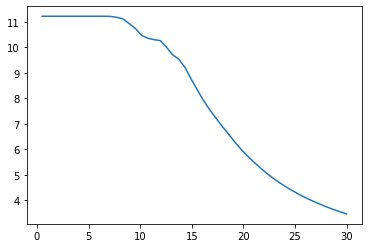

In [165]:
x = np.linspace(0.5, 30, 50)
y = []
for i in x:
    profit,final_profit = run_strategy('TAN', df, 0.015, i)
    y.append(final_profit)

plt.plot(x, y)

(407, 20) (20,)
[0.08022218 0.14985686 0.23896739 0.         0.         0.
 0.13849548 0.13852087 0.         0.         0.05107849 0.
 0.         0.04718675 0.         0.         0.10334172 0.05233026
 0.         0.        ]
(407, 20) (20,)
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
(407, 20) (20,)
AXP     0.039227
BA      0.039839
CAT     0.039432
CVX     0.056135
DIS     0.046228
IBM     0.045412
INTC    0.033669
JNJ     0.062382
JPM     0.036907
KO      0.058621
MCD     0.057970
MMM     0.059984
MRK     0.049011
PFE     0.051219
PG      0.062032
TRV     0.049375
RTX     0.050037
WBA     0.044471
WMT     0.054611
XOM     0.063436
dtype: float64
(407, 20) (20,)
[0.00236301 0.02124531 0.01290331 0.03359553 0.01401561 0.09695787
 0.00406938 0.08656444 0.01971749 0.13244618 0.13075517 0.03159992
 0.08609931 0.00392441 0.13057222 0.0732866  0.00605689 0.04799478
 0.01076897 0.0550636 ]


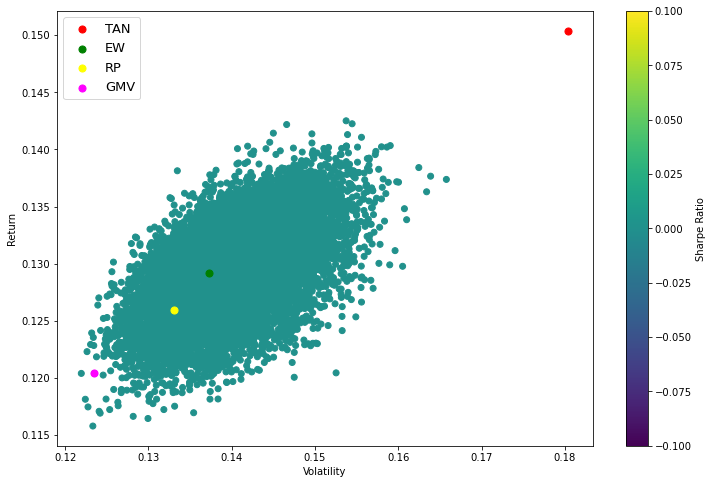

In [108]:
#d
rs_rate = 0.015

def calc_ret_std(window, weights):
    print(window.shape, weights.shape)
    ret = (1+np.sum((window.mean() * weights)))**12 - 1
    std = np.sqrt(np.dot(weights.T, np.dot(window.cov() , weights))) * np.sqrt(12)

    return ret, std


np.random.seed(42)
num_ports = 15000
risk_aversion = 20
all_weights = np.zeros((num_ports, len(df1.columns)))
ret_arr = np.zeros(num_ports)
std_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

Window = df.iloc[36:, :20]

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.uniform(0, 5, 20))
    weights = weights/np.sum(weights)


    # Save weights
    all_weights[x,:] = weights

    # Expected return
    ret_arr[x] = (1+np.sum((Window.mean() * weights)))**12 - 1

    # Expected volatility
    std_arr[x] = np.sqrt(np.dot(weights.T, np.dot(Window.cov() , weights))) * np.sqrt(12)




Window = df.iloc[36:, :20]
# TAN
weights1 = calc_weights(Window, 'TAN', RF = False)
ret1, std1 = calc_ret_std(Window, weights1)
print(weights1)

#EW
weights2 = calc_weights(Window, 'EW', RF = False)
ret2, std2 = calc_ret_std(Window, weights2)
print(weights2)

#RP
weights3 = calc_weights(Window, 'RP', RF = False)
ret3, std3 = calc_ret_std(Window, weights3)
print(weights3)

#
weights4 = calc_weights(Window, 'GMV', RF = False)
ret4, std4 = calc_ret_std(Window, weights4)
print(weights4)



plt.figure(figsize=(12,8))
plt.scatter(std_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# plt.scatter(ret1, std1,c='red', s=50, label = 'TAN') # red dot TAN
# plt.scatter(ret2, std2, c = 'green', s = 50, label = 'EW')
# plt.scatter(ret3, std3, c = 'yellow', s = 50, label = 'RP')
# plt.scatter(ret4, std4, c = 'magenta', s = 50, label = 'GMV')

plt.scatter(std1, ret1,c='red', s=50, label = 'TAN') # red dot TAN
plt.scatter(std2, ret2, c = 'green', s = 50, label = 'EW')
plt.scatter(std3, ret3, c = 'yellow', s = 50, label = 'RP')
plt.scatter(std4, ret4, c = 'magenta', s = 50, label = 'GMV')
plt.legend(prop = {'size': 13})
plt.show()




Из рисунка видно, что стратегии различаются по степени риска. Tangency портфолии явялется самым рисковым, в то время как GMV портфолио является менее рискованым

Графики роста портфолии с ежемесячной сменой весов для активов.тт

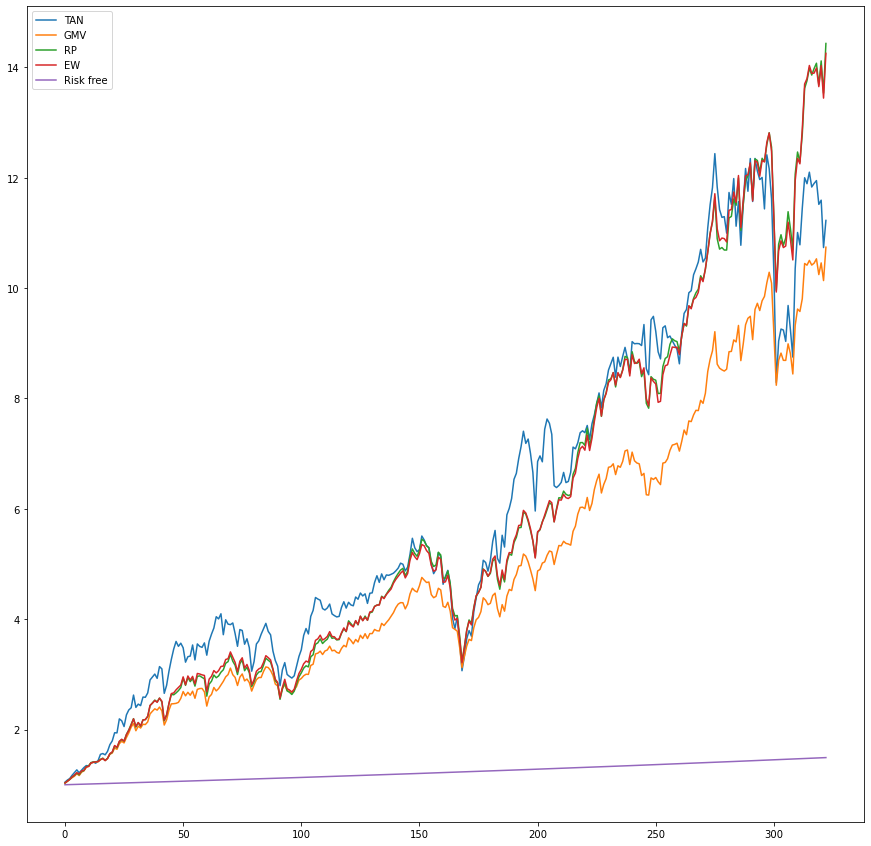

In [131]:
#h
plt.figure(figsize = (15,15))

x = np.arange(0, 323, 1)

y1 = np.cumprod(profits1 + np.ones(323))
plt.plot(x,y1, label = 'TAN')
y2 = np.cumprod(profits2 + np.ones(323))
plt.plot(x,y2, label = 'GMV')
y3 = np.cumprod(profits3 + np.ones(323))
plt.plot(x,y3, label = 'RP')
y4 = np.cumprod(profits4 + np.ones(323))
plt.plot(x,y4, label = 'EW')

rf_rate = 0.015
Rf = np.power(1 + rf_rate, 1/12)
Rf = np.cumprod(np.ones(323) * Rf)
plt.plot(x, Rf, label = 'Risk free')

plt.legend(prop = {'size': 10})
plt.show()

По графикам видно, что с учетом постоянного реинвестирования средств, наиболее эффективными являются GM и RP портфолио

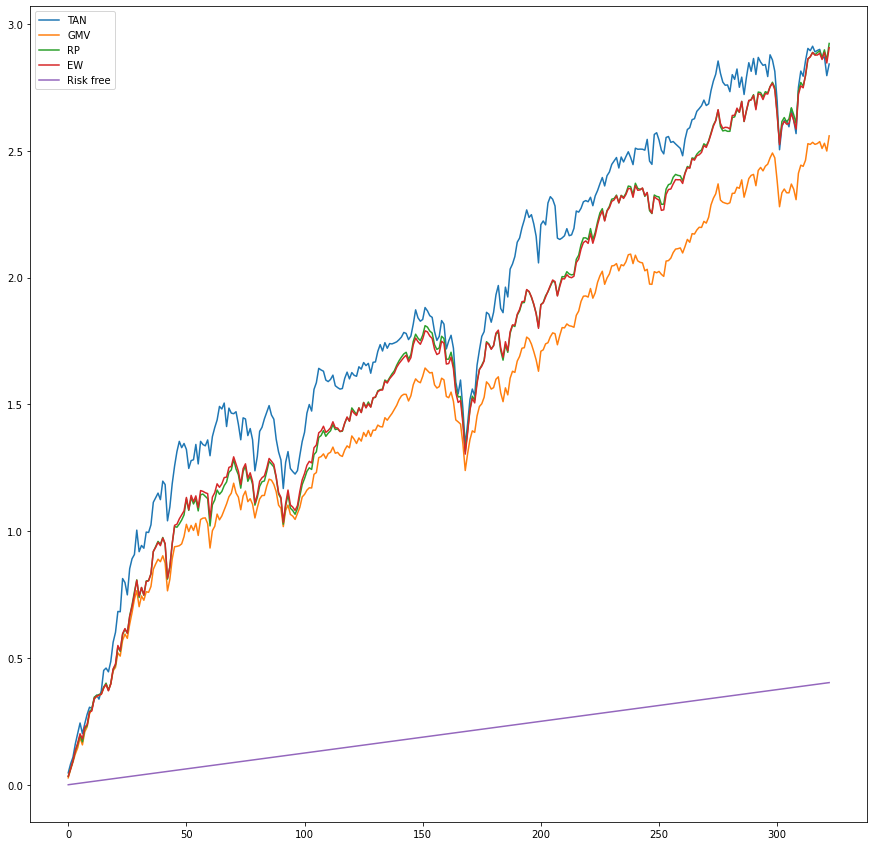

In [164]:
plt.figure(figsize = (15,15))

x = np.arange(0, 323, 1)

y1 = np.cumsum(profits1)
plt.plot(x,y1, label = 'TAN')
y2 = np.cumsum(profits2 )
plt.plot(x,y2, label = 'GMV')
y3 = np.cumsum(profits3)
plt.plot(x,y3, label = 'RP')
y4 = np.cumsum(profits4)
plt.plot(x,y4, label = 'EW')

rf_rate = 0.015
Rf = rs_rate/12
Rf = np.cumsum(np.ones(323) * Rf)
plt.plot(x, Rf, label = 'Risk free')

plt.legend(prop = {'size': 10})
plt.show()

При инвестировании одной и той же суммы каждый месяц (без реинвестирования),лучшее оказывается TAN стратегия.